In [ ]:
# Dependencies for visualization
!pip install --quiet mediapy

In [ ]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu' # Force on CPU

import sys
sys.path.insert(0, '..') # Add OCTO to python path

In [ ]:
import mediapy
import numpy as np
import jax
import flax
import pandas as pd


In [ ]:
from config import get_config
config = get_config("multimodal_switch_bridge") # Replace how you want

from experiments.karl.oxe_config import get_config
config = get_config("transformer_bc_rtx") # Replace how you want

2023-11-08 00:39:14.026621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Skipping duplicate: ('taco_play', 1.0).
Skipping duplicate: ('berkeley_cable_routing', 1.0).
Skipping duplicate: ('viola', 1.0).
Skipping duplicate: ('toto', 1.0).
Skipping berkeley_rpt_converted_externally_to_rlds since only EEF pose delta action encoding is supported.
Balancing dataset sampling ratios based on #episodes, computing sampling weights...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.98it/s]

... Done!


In [ ]:
from octo.data.dataset import make_interleaved_dataset, make_single_dataset


# Train Dataset

In [ ]:
sample_weights = (
        config.dataset_kwargs["sample_weights"]
        if "sample_weights" in config.dataset_kwargs
        else None
    )

train_data = make_interleaved_dataset(
        config.dataset_kwargs["common_kwargs"],
        config.dataset_kwargs["data_kwargs_list"],
        config.dataset_kwargs["transform_kwargs"],
        train=True,
        sample_weights=sample_weights,
        shuffle_buffer_size=config.shuffle_buffer_size,
    ).batch(config.batch_size)


######################################################################################
# Loading the following 24 datasets (incl. sampling weight):                         #
# fractal20220817_data: ====================================================0.391247 #
# kuka: ====================================================================0.094156 #
# bridge_dataset: ==========================================================0.238628 #
# taco_play: ===============================================================0.029088 #
# jaco_play: ===============================================================0.017514 #
# berkeley_cable_routing: ==================================================0.013297 #
# roboturk: ================================================================0.016114 #
# nyu_door_opening_surprising_effectiveness: ===============================0.019515 #
# viola: ===================================================================0.006056 #
# berkeley_autolab_ur5: ==================

Generating individual datasets...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.12s/it]


In [ ]:
train_data_iter = train_data.iterator()
batch = next(train_data_iter)

2023-11-08 00:40:02.783882: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: 1 } dim { size: 256 } dim { size: 256 } dim { size: -6 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2250 num_cores: 240 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 268435456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: -8 } dim { size: -9 } dim { size: -6 } } }
2

In [ ]:
print(flax.core.pretty_repr(jax.tree_map(lambda x: (x.shape, x.dtype), batch)))

{
    _traj_index: ((256,), dtype('int64')),
    action: ((256, 4, 7), dtype('float32')),
    is_last: ((256,), dtype('bool')),
    is_terminal: ((256,), dtype('bool')),
    observation: {
        image_0: ((256, 4, 256, 256, 3), dtype('uint8')),
        image_1: ((256, 4, 256, 256, 3), dtype('uint8')),
        pad_mask: ((256, 4), dtype('bool')),
        proprio: ((256, 4, 9), dtype('float32')),
        timestep: ((256, 4), dtype('int32')),
    },
    tasks: {
        end_timestep: ((256,), dtype('int32')),
        goal_timestep: ((256,), dtype('int32')),
        image_0: ((256, 256, 256, 3), dtype('uint8')),
        image_1: ((256, 256, 256, 3), dtype('uint8')),
        language_instruction: ((256,), dtype('O')),
        proprio: ((256, 9), dtype('float32')),
        timestep: ((256,), dtype('int32')),
    },
}


EMPTY STRING,,,
,,,

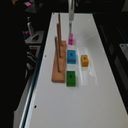
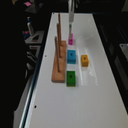
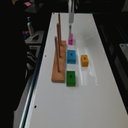
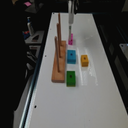
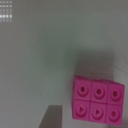
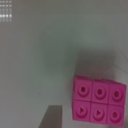
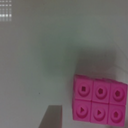
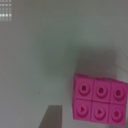

EMPTY STRING,,,
,,,

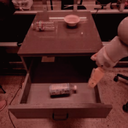
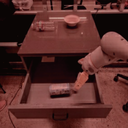
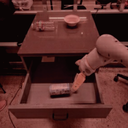
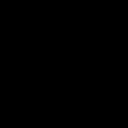
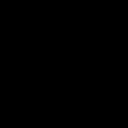
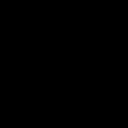
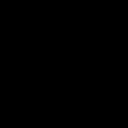

move coke can near blue plastic bottle,,,
,,,

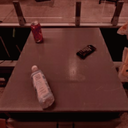
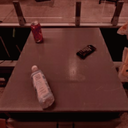
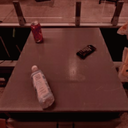
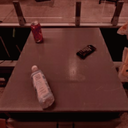
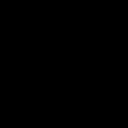
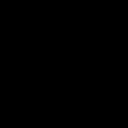
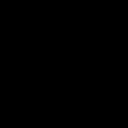
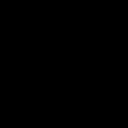

place coke can upright,,,
,,,

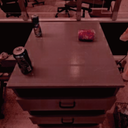
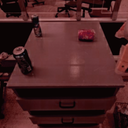
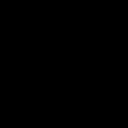
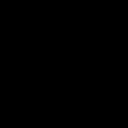
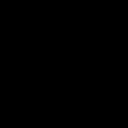
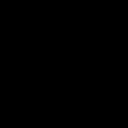

play with the kitchen,,,
,,,

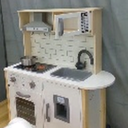
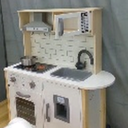
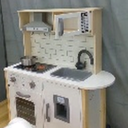
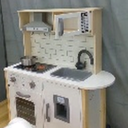
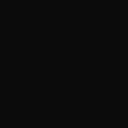
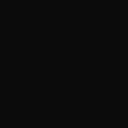
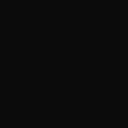
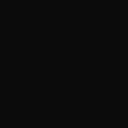

In [ ]:
N_to_show = 5
image_keys = sorted(filter(lambda k: 'image' in k, batch['observation'].keys()))

text_for_display = [t.decode('utf-8') if len(t) > 0 else 'EMPTY STRING' for t in batch['tasks']['language_instruction']]
for example in range(N_to_show):
    images = np.concatenate([
        batch['observation'][image_key][example]
        for image_key in image_keys], axis=0)
    mediapy.show_images(
        images,
        [text_for_display[example]] + [""] * (len(images)-1),
        columns=4,
        width=128,
        height=128
    )

# Single Dataset (yields trajectories)

In [ ]:
dataset_kwargs = config.dataset_kwargs["data_kwargs_list"][0]
val_data_kwargs = {
    **dataset_kwargs,
    **config.dataset_kwargs["common_kwargs"],
}
val_dataset = make_single_dataset(
    val_data_kwargs,
    config.dataset_kwargs["transform_kwargs"],
    train=False,
)

In [ ]:
val_iterator = val_dataset.iterator()
val_trajectory = next(val_iterator)

In [ ]:
image_keys = sorted(filter(lambda k: 'image' in k, val_trajectory['observation'].keys()))
videos = [
    val_trajectory['observation'][k][:, -1]
    for k in image_keys
]
mediapy.show_videos(videos, width=128, ylabel=dataset_kwargs['name'])

fractal20220817_data,"<source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAA71tZGF0AAACfwYF//973EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NSByMjkxNyAwYTg0ZDk4IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTQgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByYz1jcXAgbWJ0cmVlPTAgcXA9MjAgaXBfcmF0aW89MS40MCBwYl9yYXRpbz0xLjMwIGFxPTAAgAAAACpliIQA//70oPgU0GJjysxWvdiImDlIxpBl0ekKBOID56vgACGgR8x//YEAAAAJQZokbH/kQBNwAAAAB0GeQnivB0UAAAAIAZ5hdEn/CHgAAAAIAZ5jakn/CHkAAAAPQZpoSahBaJlMD//kQBNxAAAACUGehkURLX8HRQAAAAgBnqV0Sf8IeQAAAAgBnqdqSf8IeAAAAA9BmqxJqEFsmUwP/+RAE3AAAAAJQZ7KRRUtfwdFAAAACAGe6XRJ/wh4AAAACAGe62pJ/wh4AAAAD0Ga8EmoQWyZTA//5EATcQAAAAlBnw5FFS1/B0UAAAAIAZ8tdEn/CHkAAAAIAZ8vakn/CHgAAAAPQZszSahBbJlMD//kQBNwAAAACUGfUUUVLX8HRQAAAAgBn3JqSf8IeAAAA/ltb292AAAAbG12aGQAAAAAAAAAAAAAAAAAAAPoAAABTgABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAADI3RyYWsAAABcdGtoZAAAAAMAAAAAAAAAAAAAAAEAAAAAAAABTgAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAgAAAAIAAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAAAU4AAAIAAAEAAAAAApttZGlhAAAAIG1kaGQAAAAAAAAAAAAAAAAAADwAAAAUAFXEAAAAAAAtaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAFZpZGVvSGFuZGxlcgAAAAJGbWluZgAAABR2bWhkAAAAAQAAAAAAAAAAAAAAJGRpbmYAAAAcZHJlZgAAAAAAAAABAAAADHVybCAAAAABAAACBnN0YmwAAACWc3RzZAAAAAAAAAABAAAAhmF2YzEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAgACAAEgAAABIAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY//8AAAAwYXZjQwFkAAz/4QAXZ2QADKzZQgRoQAAAAwBAAAAeA8UKZYABAAZo6+GyyLAAAAAYc3R0cwAAAAAAAAABAAAAFAAAAQAAAAAUc3RzcwAAAAAAAAABAAAAAQAAAKhjdHRzAAAAAAAAABMAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAFAAAAAEAAABkc3RzegAAAAAAAAAAAAAAFAAAArEAAAANAAAACwAAAAwAAAAMAAAAEwAAAA0AAAAMAAAADAAAABMAAAANAAAADAAAAAwAAAATAAAADQAAAAwAAAAMAAAAEwAAAA0AAAAMAAAAFHN0Y28AAAAAAAAAAQAAADAAAABidWR0YQAAAFptZXRhAAAAAAAAACFoZGxyAAAAAAAAAABtZGlyYXBwbAAAAAAAAAAAAAAAAC1pbHN0AAAAJal0b28AAAAdZGF0YQAAAAEAAAAATGF2ZjU4LjI5LjEwMA=="" type=""video/mp4""/> This browser does not support the video tag."
